In [54]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Select a few clients

In [9]:
# inputs = pd.read_csv('Customer_data_test.csv')
# inputs.sort_values(by='SK_ID_CURR', inplace=True)
# inputs.set_index(keys='SK_ID_CURR', inplace=True)

# inputs.shape

# import seaborn as sns

# def predict_all_data(data, preprocess, model):
#     data_copy = data.copy()
#     data_customer_preprocess = preprocess.transform(data_copy)
#     y_pred = model.predict(data_customer_preprocess).tolist()
#     y_prob = model.predict_proba(data_customer_preprocess).tolist()
#     data_copy['predict'] = y_pred
#     data_copy['list_of_proba'] = y_prob
#     return data_copy

# data_predict = predict_all_data(inputs, preprocessor, lgbm_model)
# # data_predict.to_csv('CustomerDataPredicted.csv')

# data_predict.predict.value_counts()

# def extract_proba(x, i):
#     return x[i]

# data_predict_1 = data_predict[data_predict.predict == 1]
# data_predict_1['proba'] = data_predict_1.list_of_proba.apply(extract_proba, i=1)
# list_of_bad_customer_ids = data_predict_1[data_predict_1.proba > 0.87].index.tolist()

# data_predict_0 = data_predict[data_predict.predict == 0]
# data_predict_0['proba'] = data_predict_0.list_of_proba.apply(extract_proba, i=0)
# list_of_good_customer_ids = data_predict_0[data_predict_0.proba > 0.94].index.tolist()

# len(list_of_bad_customer_ids), len(list_of_good_customer_ids)

# list_few_ids = list_of_bad_customer_ids + list_of_good_customer_ids

# CustomerToBePredicted = inputs.loc[list_few_ids]
# CustomerToBePredicted.to_csv('CustomerToBePredicted.csv')

## Load preprocessor, model and data

In [55]:
preprocessor = pickle.load(open("preprocessor.pkl","rb"))
lgbm_model = pickle.load(open("lgbm_model.pkl","rb"))

In [57]:
inputs = pd.read_csv('CustomerDataToBePredicted.csv')
inputs.sort_values(by='SK_ID_CURR', inplace=True)
inputs.set_index(keys='SK_ID_CURR', inplace=True)

## Feature importance global

In [58]:
import shap

def calculate_explainer_shapval_and_means(classifier, feature_inputs):
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(feature_inputs)
    mean_values = np.abs(shap_values).mean(0)
    return explainer, shap_values, mean_values

lgbm_explainer, lgbm_shap_values, lgbm_mean_values = calculate_explainer_shapval_and_means(lgbm_model, inputs)

# filename1 = 'lgbm_explainer.pkl'
# pickle.dump(lgbm_explainer, open(filename1, 'wb'))
# filename2 = 'lgbm_shap_values.pkl'
# pickle.dump(lgbm_shap_values, open(filename2, 'wb'))
# filename3 = 'lgbm_mean_values.pkl'
# pickle.dump(lgbm_mean_values, open(filename3, 'wb'))

In [59]:
# def feature_importance_global_df(feature_inputs, mean_values):
#     feature_importance = pd.DataFrame(list(zip(feature_inputs.columns, sum(mean_values))),
#                                       columns=['feature_name', 'feature_importance_value'])
#     feature_importance.sort_values(by=['feature_importance_value'], ascending=False, inplace=True)
#     return feature_importance

In [60]:
def feature_importance_global_graphics(feature_inputs, shap_values):
    fig1 = plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, feature_inputs, plot_type='bar')
    fig2 = plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values[0], feature_inputs)
    return fig1, fig2

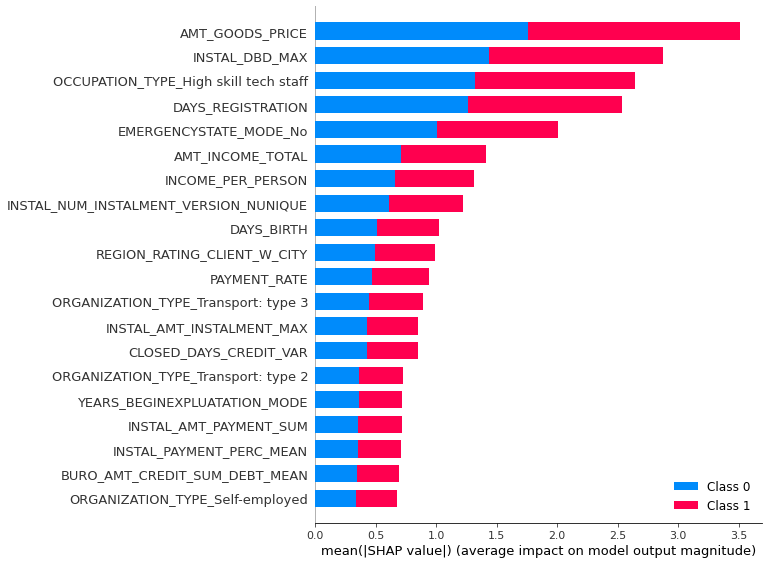

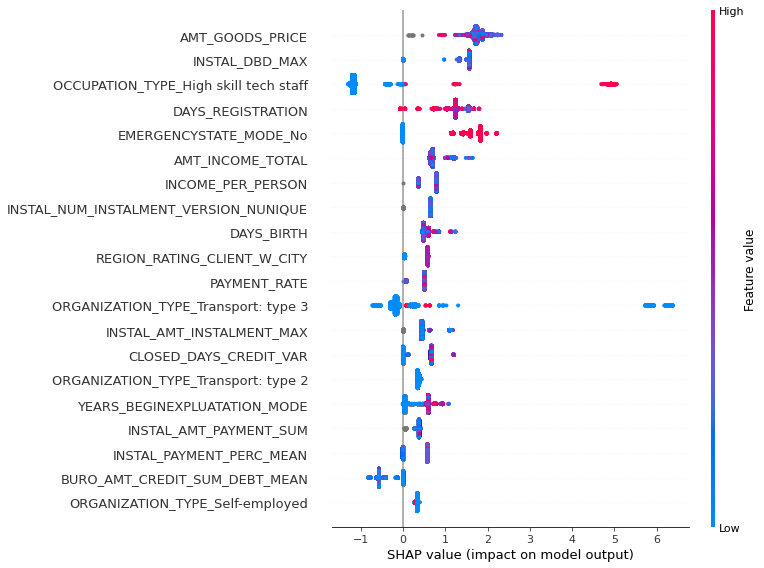

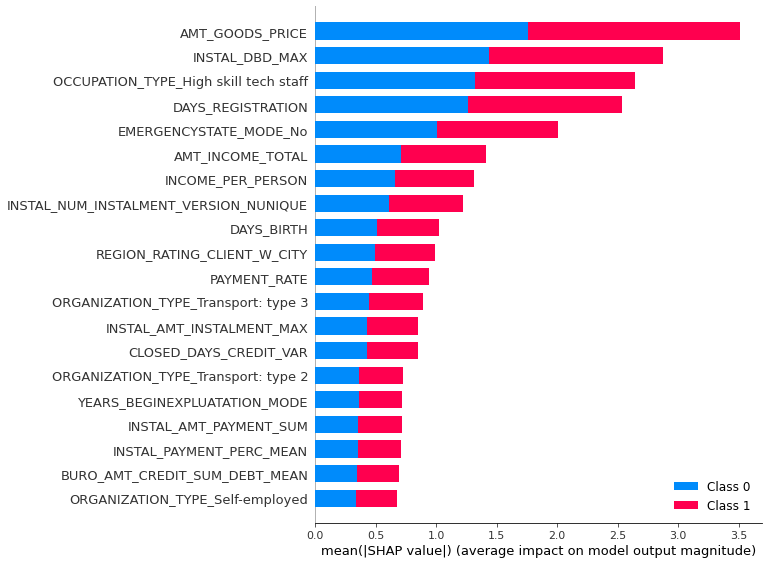

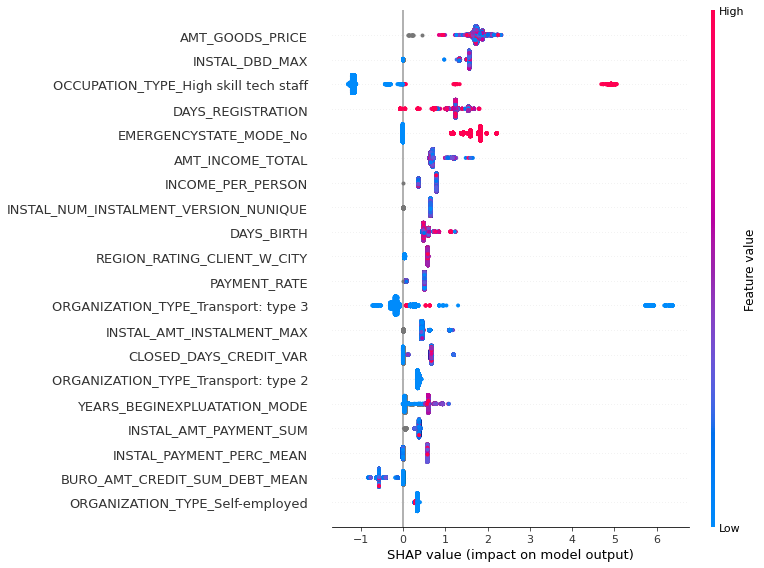

In [61]:
graph_mean_global = feature_importance_global_graphics(inputs, lgbm_shap_values)[0]
graph_shap_global = feature_importance_global_graphics(inputs, lgbm_shap_values)[1]

## Graphiques

In [62]:
discrete_variables = sorted(inputs.loc[:, inputs.nunique() < 10].columns.tolist())
continuous_variables = sorted(inputs.loc[:, inputs.nunique() >= 10].columns.tolist())
all_variables = sorted(continuous_variables + discrete_variables)

In [63]:
def predict_class_and_proba_customer(data, id_, preprocess, model):
    data_id_customer = data.loc[id_].to_frame().T
    data_customer_preprocess = preprocess.transform(data_id_customer)
    y_pred = model.predict(data_customer_preprocess)[0]
    y_prob = model.predict_proba(data_customer_preprocess)[0].tolist()
    if y_pred == 0:
        return "Prêt accordé" + " ->  Probabilité:" + f"{y_prob[0]}"
    else:
        return "Prêt Refusé" + " ->  Probabilité:" + f"{y_prob[1]}"


def feature_importance_local_graphics(id_, top_n_features):
    index_id_ = list_of_ids_in_order.index(id_)
    fig = plt.figure(figsize=(10, 8))
    shap.plots._waterfall.waterfall_legacy(lgbm_explainer.expected_value[1], lgbm_shap_values[0][index_id_],
                                           features=inputs.loc[id_], max_display=top_n_features)
    plt.show()
    return fig

def boxplot_by_feature(df, feature_name):
    fig1 = plt.figure(figsize=(10, 8))
    sns.boxplot(data=df[[feature_name]], showfliers=False, showmeans=True)
    fig1.show()
    fig2 = plt.figure(figsize=(10, 8))
    sns.boxplot(x='predict', y=feature_name, showfliers=False, showmeans=True, data=df)
    fig2.show()
    return fig1, fig2

def barplot_by_feature(df, feature_name):
    fig = plt.figure(figsize=(10, 8))
    df = df.copy()
    df['iniatialize'] = 1
    df = df[[feature_name, 'predict', 'iniatialize']].groupby([feature_name, 'predict']).count().reset_index()
    sns.barplot(x=df.NAME_CONTRACT_TYPE, y=df.iniatialize, hue=df.predict)
    plt.xticks(rotation=0)
    fig.show()
    return fig

def box_or_bar_plot(df, feature_name, id_):
    if feature_name in continuous_variables:
        boxplot_by_feature(df, feature_name)
        print('Value: ', df.loc[id_][feature_name])
    else:
        barplot_by_feature(df, feature_name)
        print('Value: ', df.loc[id_][feature_name])

## Select a proba treshold

In [64]:
def extract_proba(x, i):
    return x[i]

list_of_ids_in_order = inputs.index.tolist()

data_predict_1 = data_predict[data_predict.predict == 1]
data_predict_1['proba'] = data_predict_1.list_of_proba.apply(extract_proba, i=1)
list_of_worst_customer_ids = data_predict_1[data_predict_1.proba > 0.95].head(10).index.tolist()

data_predict_0 = data_predict[data_predict.predict == 0]
data_predict_0['proba'] = data_predict_0.list_of_proba.apply(extract_proba, i=0)
list_of_best_customer_ids = data_predict_0[data_predict_0.proba > 0.95].head(10).index.tolist()

In [65]:
user_id = 100396

In [66]:
predict_class_and_proba_customer(data=inputs, id_=user_id, preprocess=preprocessor, model=lgbm_model)

'Prêt Refusé ->  Probabilité:0.9775383547680007'

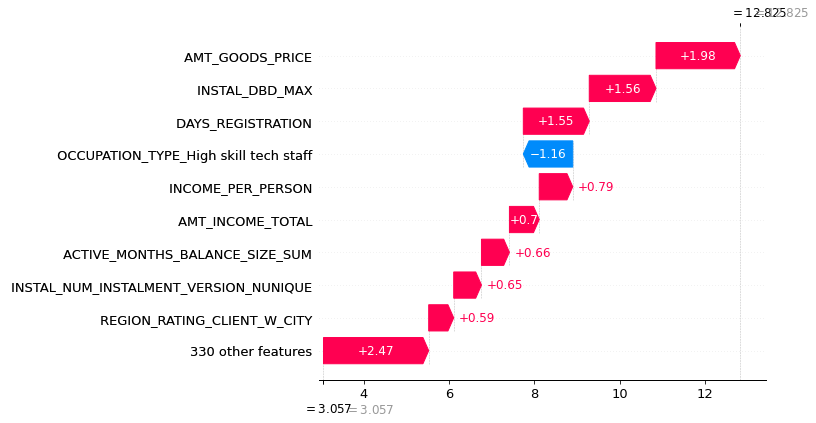

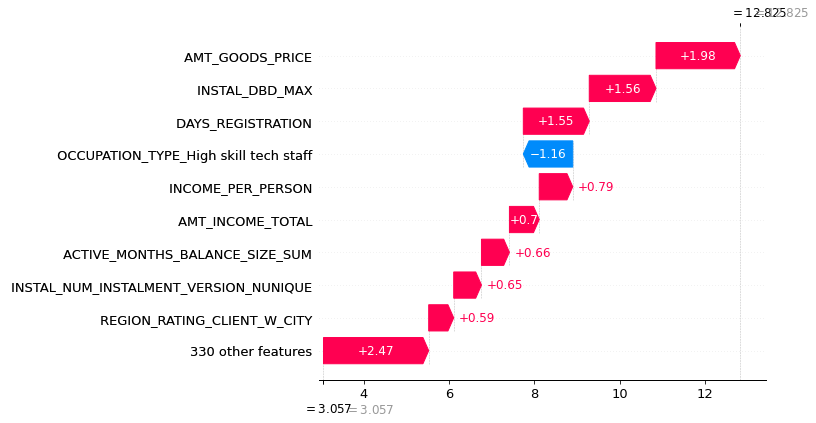

In [67]:
feature_importance_local_graph = feature_importance_local_graphics(id_=user_id, top_n_features=10)
feature_importance_local_graph

In [68]:
user_feature = 'AMT_GOODS_PRICE'

Value:  360000.0


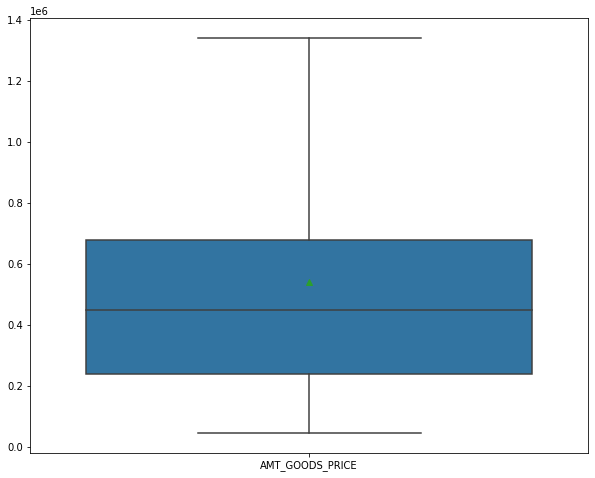

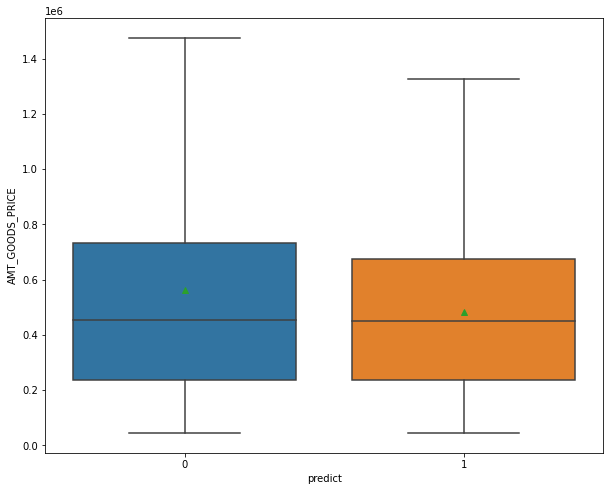

In [69]:
box_or_bar_plot(df=data_predict, feature_name=user_feature, id_=user_id)

## Clean Description

In [70]:
def load_and_clean_description():
    df = pd.read_csv('input/HomeCredit_columns_description.csv', index_col=0)
    df.sort_values(by='Row', inplace=True)
    df = df[['Row', 'Description']]
    df.drop_duplicates(inplace=True)
    df.drop([179, 141, 176, 145, 150, 173, 126, 178, 174, 197, 152, 181, 185, 183, 155, 184, 125], inplace=True)
    return df

In [71]:
hc_col_desc = load_and_clean_description()
hc_col_desc

,Row,Description
12,AMT_ANNUITY,Loan annuity
180,AMT_APPLICATION,For how much credit did client ask on the prev...
156,AMT_BALANCE,Balance during the month of previous credit
11,AMT_CREDIT,Credit amount of the loan
157,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
...,...,...
77,YEARS_BEGINEXPLUATATION_MEDI,Normalized information about building where th...
63,YEARS_BEGINEXPLUATATION_MODE,Normalized information about building where th...
50,YEARS_BUILD_AVG,Normalized information about building where th...
78,YEARS_BUILD_MEDI,Normalized information about building where th...


In [72]:
# hc_col_desc.to_csv('home_credit_feature_description.csv', index=False)

In [73]:
def print_description(df_description, feature_name):
    print(hc_col_desc[hc_col_desc.Row == feature_name].Description.values[0])

In [74]:
query = 'CODE_GENDER'
print_description(df_description=hc_col_desc, feature_name=query)

Gender of the client


## Nouvelles variables
### Par le calcul
- DAYS_EMPLOYED_PERC = DAYS_EMPLOYED / DAYS_BIRTH
- INCOME_CREDIT_PERC = AMT_INCOME_TOTAL / AMT_CREDIT
- INCOME_PER_PERSON = AMT_INCOME_TOTAL / CNT_FAM_MEMBERS
- ANNUITY_INCOME_PERC = AMT_ANNUITY/ AMT_INCOME_TOTAL
- PAYMENT_RATE = AMT_ANNUITY / AMT_CREDIT

- PAYMENT_PERC = AMT_PAYMENT / AMT_INSTALMENT (Percentage paid in each installment (amount paid and installment value))
- PAYMENT_DIFF = AMT_INSTALMENT - AMT_PAYMENT (Difference paid in each installment (amount paid and installment value))
- DPD = DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT (Days past due)
- DBD = DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT (days before due)

### Minimum, Maximum, Moyenne, Vaiance, Somme (Ajout suffixe)
- Ajout de min, max, mean, var, sum en suffixe pour certaines variables

### Ajout préfixe selon les données d'où est extraite la variable
- BURO_,
- ACTIVE_ (Crédit activé)
- CLOSED_ (Crédit fermé)
- POS_ ( (point of sales) and cash loans) et POS_COUNT (cash)
- INSTAL_ et INSTAL_COUNT
- CC_ et CC_COUNT (carte de crédit)